# Understanding model optimization

## Why optimization is hard
* Simultaneously optimizing 1000s of parameters with complex relationships
* Updates may not improve model meaningfully
* Updates too small (if learning rate is low) or too large (if learning rate is high)

## Stochastic gradient descent

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('titanic_all_numeric.csv')
X = df.drop(['survived'], axis=1).values.astype('float64')
y = to_categorical(df.survived)
X.shape, y.shape

((891, 10), (891, 2))

In [3]:
from tensorflow.keras.optimizers import SGD
def get_new_model(input_shape):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return(model)

learning_rates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# Loop over learning rates
for lr in learning_rates:
    model = get_new_model((X.shape[1],))
    my_optimizer = SGD(learning_rate=lr)
    model.compile(optimizer = my_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
    print(f'{lr=}')
    model.fit(X, y)

lr=1e-06
28/28 [==============================] - 1s 876us/step - loss: 2.9858 - accuracy: 0.3838
lr=1e-05
28/28 [==============================] - 0s 849us/step - loss: 3.4295 - accuracy: 0.4400
lr=0.0001
28/28 [==============================] - 0s 802us/step - loss: 1.8595 - accuracy: 0.3749
lr=0.001
28/28 [==============================] - 0s 795us/step - loss: 0.8564 - accuracy: 0.6667
lr=0.01
28/28 [==============================] - 0s 824us/step - loss: 1.4417 - accuracy: 0.6330
lr=0.1
28/28 [==============================] - 0s 766us/step - loss: 5.3964 - accuracy: 0.5960
lr=1
28/28 [==============================] - 0s 785us/step - loss: 117940512.0000 - accuracy: 0.5915


## The dying neuron problem

This problem occurs when a neuron takes a value less than 0 for all rows of your data.

Recall that, with the ReLU activation function, any node with a negative input value produces an output of 0, and it also has a slope of 0 as you see in this graph.

Because the slope is 0, the slope of any weights flowing into that node are also 0. So those weights don't get updated.

In other words, once the node starts always getting negative inputs, it may continue only getting negative inputs.

It's contributing nothing to the model at this point, and hence the claim that the node or neuron is "dead".

At first, this might suggest using an activation function whose slope is never exactly zero. However, those types of functions were used for many years.

## Vanishing gradients
* Occurs when many layers have very small slopes (e.g. due to being on flat part of tanh curve)
* In deep networks, updates to backprop were close to 0

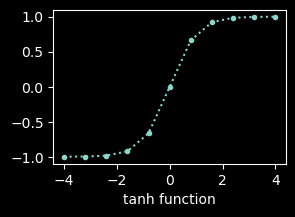

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')
ls = np.linspace(-4, 4, 11)
plt.figure(figsize=(3,2)); plt.plot(ls, np.tanh(ls), '.:'); plt.xlabel('tanh function'); plt.show()

For example, in an earlier video we used an s-shaped function called tanh. However, values that were outside the middle of the S were relatively flat, or had small slopes.  
A small but non-zero slope might work in a network with only a few hidden layers. But in a deep network, one with many layers, the repeated multiplication of small slopes causes the slopes to get close to 0, which meant updates in backprop were close to 0.  
This is called the vanishing gradient problem. This in turn might suggest using an activation function that isn't even close to flat anywhere.
There is research in this area, including variations on ReLU. Those aren't widely used though.
For now, it's a phenomenon worth keeping in mind if you are ever pondering why your model isn't training better. If it happens, changing the activation function may be the solution.

# Model validation

## Validation in deep learning
* Commonly use validation split rather than cross-validation
* Deep learning widely used on large datasets
* Single validation score is based on large amount of data, and is reliable
* Repeated training from cross-validation would take long time

In [5]:
model = get_new_model((X.shape[1],))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_split=0.3, epochs=20)

Epoch 1/20
20/20 [==============================] - 0s 5ms/step - loss: 1.3843 - accuracy: 0.6132 - val_loss: 0.8263 - val_accuracy: 0.7015
Epoch 2/20
20/20 [==============================] - 0s 1ms/step - loss: 0.7434 - accuracy: 0.6388 - val_loss: 0.5579 - val_accuracy: 0.7090
Epoch 3/20
20/20 [==============================] - 0s 1ms/step - loss: 0.7324 - accuracy: 0.6517 - val_loss: 0.5359 - val_accuracy: 0.7351
Epoch 4/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6294 - accuracy: 0.6758 - val_loss: 0.5650 - val_accuracy: 0.6903
Epoch 5/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6177 - accuracy: 0.6742 - val_loss: 0.5315 - val_accuracy: 0.7537
Epoch 6/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6575 - accuracy: 0.6790 - val_loss: 0.5767 - val_accuracy: 0.6754
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 0.5830 - accuracy: 0.6790 - val_loss: 0.5733 - val_accuracy: 0.6791
Epoch 8/20
20/20 [==

## Early Stopping

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

model = get_new_model((X.shape[1],))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# patience: how many epochs the model can go without improving before we stop training
# 2 or 3 are reasonable values for patience
early_stopping_monitor = EarlyStopping(patience=2)

# by default Keras trains for 10 epochs
model.fit(X, y, validation_split=0.3, epochs=20,
          callbacks = [early_stopping_monitor])

Epoch 1/20
20/20 [==============================] - 0s 4ms/step - loss: 0.9528 - accuracy: 0.6019 - val_loss: 0.6296 - val_accuracy: 0.6642
Epoch 2/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6794 - accuracy: 0.6629 - val_loss: 0.5344 - val_accuracy: 0.7761
Epoch 3/20
20/20 [==============================] - 0s 1ms/step - loss: 0.6056 - accuracy: 0.6934 - val_loss: 0.5387 - val_accuracy: 0.7239
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6238 - accuracy: 0.6726 - val_loss: 0.5509 - val_accuracy: 0.7761


## Experimentation
* Experiment with different architectures
* More layers
* Fewer layers
* Layers with more nodes
* Layers with fewer nodes
* Creating a great model requires experimentation

## Evaluating model accuracy on validation dataset

In [7]:
# Specify the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (X.shape[1], )))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
hist = model.fit(X, y, validation_split=0.3)

20/20 [==============================] - 0s 4ms/step - loss: 1.3252 - accuracy: 0.5891 - val_loss: 0.8122 - val_accuracy: 0.7313


## Early stopping: Optimizing the optimization

In [8]:
# Import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

# Specify the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (X.shape[1], )))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model.fit(X, y , epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Epoch 1/30
20/20 [==============================] - 0s 4ms/step - loss: 1.2886 - accuracy: 0.5811 - val_loss: 0.5467 - val_accuracy: 0.7388
Epoch 2/30
20/20 [==============================] - 0s 2ms/step - loss: 0.7972 - accuracy: 0.6083 - val_loss: 0.6013 - val_accuracy: 0.6978
Epoch 3/30
20/20 [==============================] - 0s 1ms/step - loss: 0.6609 - accuracy: 0.6645 - val_loss: 0.5122 - val_accuracy: 0.7351
Epoch 4/30
20/20 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.6645 - val_loss: 0.5173 - val_accuracy: 0.7388
Epoch 5/30
20/20 [==============================] - 0s 2ms/step - loss: 0.5828 - accuracy: 0.6870 - val_loss: 0.5783 - val_accuracy: 0.7388


## Experimenting with wider networks

In [9]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)
# Create the new model: model_2
model_1 = Sequential()
# Add the first and second layers
model_1.add(Dense(10, activation='relu', input_shape=(X.shape[1], )))
model_1.add(Dense(10, activation='relu', input_shape=(X.shape[1], )))
# Add the output layer
model_1.add(Dense(2, activation='softmax'))
# Compile model_2
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                110       
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 2)                 22        
                                                                 
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Create the new model: model_2
model_2 = Sequential()
# Add the first and second layers
model_2.add(Dense(100, activation='relu', input_shape=(X.shape[1], )))
model_2.add(Dense(100, activation='relu', input_shape=(X.shape[1], )))
# Add the output layer
model_2.add(Dense(2, activation='softmax'))
# Compile model_2
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               1100      
                                                                 
 dense_37 (Dense)            (None, 100)               10100     
                                                                 
 dense_38 (Dense)            (None, 2)                 202       
                                                                 
Total params: 11,402
Trainable params: 11,402
Non-trainable params: 0
_________________________________________________________________


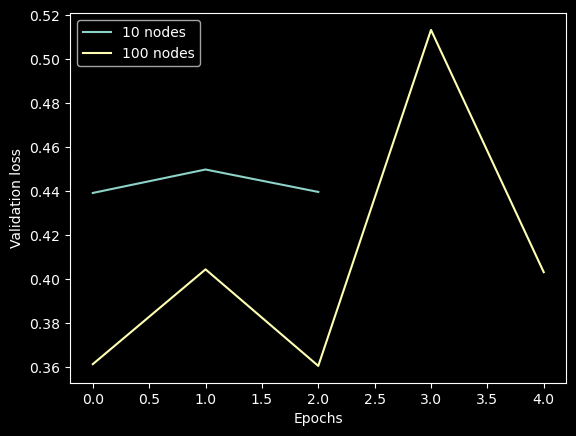

In [24]:
# Fit model_1
model_1_training = model_1.fit(X, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)
# Fit model_2
model_2_training = model_2.fit(X, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)
# Create the plot
plt.plot(model_1_training.history['val_loss'], label='10 nodes')
plt.plot(model_2_training.history['val_loss'], label='100 nodes')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

## Adding layers to a network

In [25]:
model_1 = Sequential()
model_1.add(Dense(10, activation='relu', input_shape=(X.shape[1], )))
model_1.add(Dense(2, activation='softmax'))
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 10)                110       
                                                                 
 dense_40 (Dense)            (None, 2)                 22        
                                                                 
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_2 = Sequential()
model_2.add(Dense(10, activation='relu', input_shape=(X.shape[1], )))
model_2.add(Dense(10, activation='relu', input_shape=(X.shape[1], )))
model_2.add(Dense(10, activation='relu', input_shape=(X.shape[1], )))
model_2.add(Dense(2, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 10)                110       
                                                                 
 dense_42 (Dense)            (None, 10)                110       
                                                                 
 dense_43 (Dense)            (None, 10)                110       
                                                                 
 dense_44 (Dense)            (None, 2)                 22        
                                                                 
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________


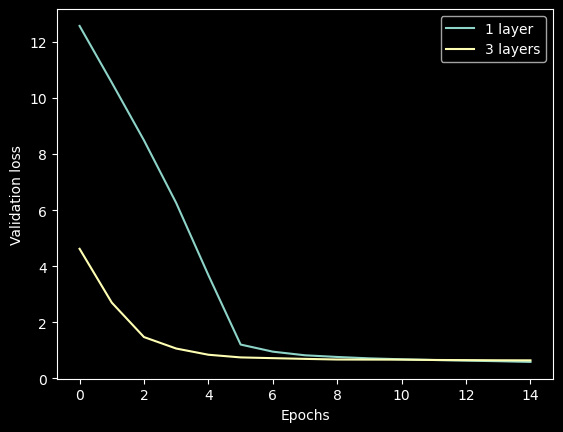

In [27]:
model_1_training = model_1.fit(X, y, epochs=15, validation_split=0.4, verbose=False)
model_2_training = model_2.fit(X, y, epochs=15, validation_split=0.4, verbose=False)

# Create the plot
plt.plot(model_1_training.history['val_loss'], label='1 layer')
plt.plot(model_2_training.history['val_loss'], label='3 layers')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

# Thinking about model capacity

* Model capacity is a model's ability to capture predictive patterns in your data.
* The more capacity a model, the lower the bias and the higher the variance.
* If you had a network, and you increased the number of nodes or neurons in a hidden layer, that would increase model capacity.
* And if you add layers, that increases capacity.
* Said another way, making larger layers or increasing the number of layers will lower the bias and increase the variance.

## Workflow for optimizing model capacity
* Start with a small network
* Gradually increase capacity
* Keep increasing capacity until validation score is no longer improving
* Once it stops improving, you can decrease capacity slighty, but you are probably near the ideal.

# Stepping up to images

## Recognizing handwritten digits
MNIST dataset
* 28 x 28 grid  flattened to 784 values for each image
* Value in each part of array denotes darkness of that pixel

In [28]:
df = pd.read_csv('mnist.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.61,0.611,0.612,0.613,0.614,0.615,0.616,0.617
1,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1997,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1998,8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1999,9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Building your own digit recognition model

### 2001x784 samples

In [29]:
X = df.drop(columns=[0]).values
y = to_categorical(df[0])
print(f'{X.shape=} {y.shape=}')
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(X.shape[1], )))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X.shape=(2001, 784) y.shape=(2001, 10)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 50)                39250     
                                                                 
 dense_46 (Dense)            (None, 50)                2550      
                                                                 
 dense_47 (Dense)            (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X, y, validation_split=0.3, epochs=10)

Epoch 1/10
44/44 [==============================] - 0s 3ms/step - loss: 21.3067 - accuracy: 0.4157 - val_loss: 9.9328 - val_accuracy: 0.5225
Epoch 2/10
44/44 [==============================] - 0s 1ms/step - loss: 4.3133 - accuracy: 0.6964 - val_loss: 5.1190 - val_accuracy: 0.6439
Epoch 3/10
44/44 [==============================] - 0s 1ms/step - loss: 1.8701 - accuracy: 0.8271 - val_loss: 4.5672 - val_accuracy: 0.6805
Epoch 4/10
44/44 [==============================] - 0s 1ms/step - loss: 1.0565 - accuracy: 0.8771 - val_loss: 4.4296 - val_accuracy: 0.7155
Epoch 5/10
44/44 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.9107 - val_loss: 4.3147 - val_accuracy: 0.7205
Epoch 6/10
44/44 [==============================] - 0s 1ms/step - loss: 0.3689 - accuracy: 0.9329 - val_loss: 4.1782 - val_accuracy: 0.7304
Epoch 7/10
44/44 [==============================] - 0s 1ms/step - loss: 0.4387 - accuracy: 0.9343 - val_loss: 3.8361 - val_accuracy: 0.7454
Epoch 8/10
44/44 [=

### 60000x28x28 samples

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# why /255? probably make image negative
# X_train, X_test = X_train / 255.0, X_test / 255.0
print(f'{X_train.shape=} {y_train.shape=}, {X_test.shape=} {y_test.shape=}')

model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_train.shape=(60000, 28, 28) y_train.shape=(60000, 10), X_test.shape=(10000, 28, 28) y_test.shape=(10000, 10)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_48 (Dense)            (None, 50)                39250     
                                                                 
 dense_49 (Dense)            (None, 50)                2550      
                                                                 
 dense_50 (Dense)            (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
1313/1313 [==============================] - 1s 1ms/step - loss: 1.9405 - accuracy: 0.8031 - val_loss: 0.5555 - val_accuracy: 0.8745
Epoch 2/10
1313/1313 [==============================] - 1s 962us/step - loss: 0.4341 - accuracy: 0.8942 - val_loss: 0.3865 - val_accuracy: 0.9073
Epoch 3/10
1313/1313 [==============================] - 1s 981us/step - loss: 0.3252 - accuracy: 0.9165 - val_loss: 0.3669 - val_accuracy: 0.9152
Epoch 4/10
1313/1313 [==============================] - 1s 954us/step - loss: 0.2823 - accuracy: 0.9263 - val_loss: 0.3461 - val_accuracy: 0.9198
Epoch 5/10
1313/1313 [==============================] - 1s 975us/step - loss: 0.2500 - accuracy: 0.9344 - val_loss: 0.2953 - val_accuracy: 0.9283
Epoch 6/10
1313/1313 [==============================] - 1s 960us/step - loss: 0.2263 - accuracy: 0.9403 - val_loss: 0.2779 - val_accuracy: 0.9334
Epoch 7/10
1313/1313 [==============================] - 1s 977us/step - loss: 0.2019 - accuracy: 0.9459 - val_loss: 0.2581 - v

In [34]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 638us/step - loss: 0.2852 - accuracy: 0.9322


[0.2851737439632416, 0.932200014591217]

# Next steps
* Start with standard prediction problems on tables of numbers
* Images (with convolutional neural networks) are common next steps
* keras.io for excellent documentation
* Graphical processing unit (GPU) provides dramatic speedups in model training times
* Need a CUDA compatible GPU
* For training on using GPUs in the cloud look here:
    * https://www.datacamp.com/community/tutorials/deep-learning-jupyter-aws